# ASSIGNMENT 2 -- YUHENG DU

In [58]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [59]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)



In [60]:
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))
    return Y

In [61]:
def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [62]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [63]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
    else:
        conf_mult= 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1])
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [64]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

In [65]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat 
    size = np.mean(1*(np.abs(tval)>cval))
    return (bias,rmse,size)

In [101]:
import pandas as pd
import numpy as np
import graphviz as gr

from matplotlib import style

ModuleNotFoundError: No module named 'graphviz'

In [67]:
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [68]:
def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# PART 1 

In part 1, I used Howard S. Bloom, Lashawn Richburg-Hayes and Alison Rebeck Black's artticle to analyze the role of covariates in experiments with random variables. In the author's study, the authors use statistical control for covariates to improve the study of randomized schools to measure the impact of educational interventions on student achievement. accuracy. In the author's randomized trial the author's interpretation of covariate includes education, class and creativity, while covariate is the number of years.

reference： Bloom, H. S., Richburg-Hayes, L., &amp; Black, A. R. (2007, March 1). Using covariates to improve precision for studies that ...Using Covariates to Improve Precision for Studies That Randomize Schools to Evaluate Educational Interventions. Retrieved April 10, 2022, from https://journals.sagepub.com/doi/10.3102/0162373707299550 

# 1.A NO not control for any covariates
$y_i = \tau*T_i+e_i$

In [50]:
data_source = "https://raw.githubusercontent.com/datadesk/LAUSD-2020-grades/main/input/all-grades-complete.csv"
data = pd.read_csv(data_source) #the csv data of the grade of high school studends in Los Angeles 
data

,Grades,Semester School Year,# of As,# of B's,# of C's,# of D's,# of F's,# of P's,# of N's,# of I's,Total Marks,% A,% B,% C,A-C %,% D,% F,% P,% N,% I
0,9 to 12,FALL SEMESTER 2018-2019,"3 01,382","2 17,981","189,163","90,078","101,893","11,342","21,044","1,308","934,191",32.30%,23.30%,20.20%,75.80%,9.60%,10.90%,1.20%,2.30%,0.10%
1,9 to 12,SPRING SEMESTER 2018-2019,"2 99,486","2 10,384","192,475","88,218","103,546","15,044","22,173","1,200","932,526",32.10%,22.60%,20.60%,75.30%,9.50%,11.10%,1.60%,2.40%,0.10%
2,9 to 12,FALL SEMESTER 2019-2020,"3 06,029","2 16,670","186,161","88,136","95,144","11,645","19,570","1,149","924,504",33.10%,23.40%,20.10%,76.70%,9.50%,10.30%,1.30%,2.10%,0.10%
3,9 to 12,SPRING SEMESTER 2019-2020,"3 75,722","1 91,543","190,640","122,518",49,"12,584","13,760",742,"907,558",41.40%,21.10%,21.00%,83.50%,13.50%,0.00%,1.40%,1.50%,0.10%
4,9 to 12,FALL SEMESTER 2020-2021,"3 13,109","1 57,401","148,168","121,639","106,001","127,461","3,566",372,"977,717",32.00%,16.10%,15.20%,63.30%,12.40%,10.80%,13.00%,0.40%,0.00%
5,9 to 12,SPRING SEMESTER 2020-2021,"3 08,459","1 49,633","145,530","113,384","125,127","123,639","5,255","1,028","972,055",31.70%,15.40%,15.00%,62.10%,11.70%,12.90%,12.70%,0.50%,0.10%
6,6 to 8,FALL SEMESTER 2018-2019,"2 21,624","1 65,766","130,205","67,168","54,945","10,174","66,995",155,"717,032",30.90%,23.10%,18.20%,72.20%,9.40%,7.70%,1.40%,9.30%,0.00%
7,6 to 8,SPRING SEMESTER 2018-2019,"2 14,864","1 59,205","131,509","67,244","65,109","9,029","67,722",64,"714,746",30.10%,22.30%,18.40%,70.70%,9.40%,9.10%,1.30%,9.50%,0.00%
8,6 to 8,FALL SEMESTER 2019-2020,"2 21,648","1 63,995","126,887","65,126","51,454","9,242","58,241",77,"696,670",31.80%,23.50%,18.20%,73.60%,9.30%,7.40%,1.30%,8.40%,0.00%
9,6 to 8,SPRING SEMESTER 2019-2020,"2 68,367","1 52,159","143,007","70,903",-,"8,713","48,314",7,"691,470",38.80%,22.00%,20.70%,81.50%,10.30%,0.00%,1.30%,7.00%,0.00%


In [51]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # there are not covariates
Nrange = range(10,1000,10) 
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 451.07it/s]


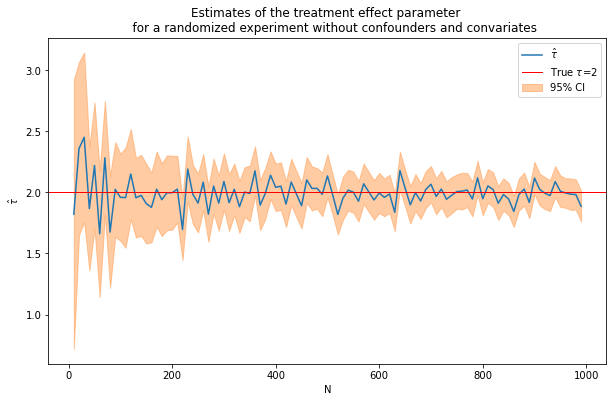

In [52]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders and convariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [53]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [54]:
tauhat,se_tauhat

(1.8437590442784175, 0.2005602513782043)

In [55]:
const = np.ones([N,1])

In [56]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(1.843759044278417, 0.20056025137820435)

In [70]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 202.67it/s]


In [71]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.004795725120067725, RMSE=0.2033792160513766, size=0.059
N=1000: bias=-0.0032101603185605847, RMSE=0.06280634666199474, size=0.048


Real life example: For example, in the research experiment I mentioned in part 1, when we want to study the effect of school on student achievement, we do not consider covariates, we only study the effect of explanatory variables on student achievement. Our explanatory variables include education and class.

In [89]:
g=gr.Digraph()
g.edge("class(C)","Achievement(Y)")
g.edge("education(E)","Achievement(Y)")
g
#class influence student achievement
#eduaction influce student achievement 

NameError: name 'gr' is not defined

# 1.B control for covariates

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [72]:
data_source = "https://raw.githubusercontent.com/datadesk/LAUSD-2020-grades/main/input/all-grades-complete.csv"
data = pd.read_csv(data_source) #the csv data of the grade of high school studends in Los Angeles 
data

,Grades,Semester School Year,# of As,# of B's,# of C's,# of D's,# of F's,# of P's,# of N's,# of I's,Total Marks,% A,% B,% C,A-C %,% D,% F,% P,% N,% I
0,9 to 12,FALL SEMESTER 2018-2019,"3 01,382","2 17,981","189,163","90,078","101,893","11,342","21,044","1,308","934,191",32.30%,23.30%,20.20%,75.80%,9.60%,10.90%,1.20%,2.30%,0.10%
1,9 to 12,SPRING SEMESTER 2018-2019,"2 99,486","2 10,384","192,475","88,218","103,546","15,044","22,173","1,200","932,526",32.10%,22.60%,20.60%,75.30%,9.50%,11.10%,1.60%,2.40%,0.10%
2,9 to 12,FALL SEMESTER 2019-2020,"3 06,029","2 16,670","186,161","88,136","95,144","11,645","19,570","1,149","924,504",33.10%,23.40%,20.10%,76.70%,9.50%,10.30%,1.30%,2.10%,0.10%
3,9 to 12,SPRING SEMESTER 2019-2020,"3 75,722","1 91,543","190,640","122,518",49,"12,584","13,760",742,"907,558",41.40%,21.10%,21.00%,83.50%,13.50%,0.00%,1.40%,1.50%,0.10%
4,9 to 12,FALL SEMESTER 2020-2021,"3 13,109","1 57,401","148,168","121,639","106,001","127,461","3,566",372,"977,717",32.00%,16.10%,15.20%,63.30%,12.40%,10.80%,13.00%,0.40%,0.00%
5,9 to 12,SPRING SEMESTER 2020-2021,"3 08,459","1 49,633","145,530","113,384","125,127","123,639","5,255","1,028","972,055",31.70%,15.40%,15.00%,62.10%,11.70%,12.90%,12.70%,0.50%,0.10%
6,6 to 8,FALL SEMESTER 2018-2019,"2 21,624","1 65,766","130,205","67,168","54,945","10,174","66,995",155,"717,032",30.90%,23.10%,18.20%,72.20%,9.40%,7.70%,1.40%,9.30%,0.00%
7,6 to 8,SPRING SEMESTER 2018-2019,"2 14,864","1 59,205","131,509","67,244","65,109","9,029","67,722",64,"714,746",30.10%,22.30%,18.40%,70.70%,9.40%,9.10%,1.30%,9.50%,0.00%
8,6 to 8,FALL SEMESTER 2019-2020,"2 21,648","1 63,995","126,887","65,126","51,454","9,242","58,241",77,"696,670",31.80%,23.50%,18.20%,73.60%,9.30%,7.40%,1.30%,8.40%,0.00%
9,6 to 8,SPRING SEMESTER 2019-2020,"2 68,367","1 52,159","143,007","70,903",-,"8,713","48,314",7,"691,470",38.80%,22.00%,20.70%,81.50%,10.30%,0.00%,1.30%,7.00%,0.00%


In [110]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 3 #there are covaraites
Nrange = range(10,1000,10) 
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 433.77it/s]


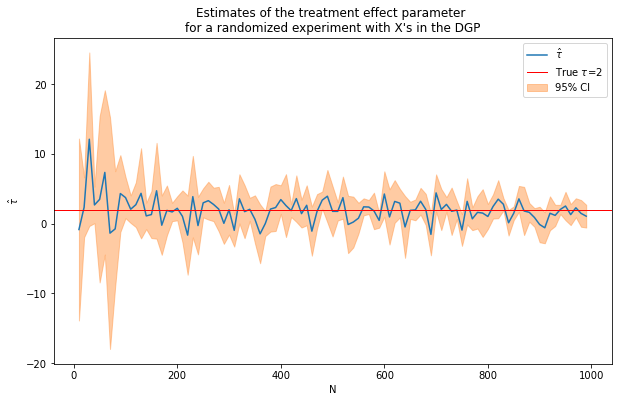

In [111]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [112]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,3,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [113]:
tauhat,se_tauhat

(-3.3739986712227092, 2.532888939773728)

In [114]:
const = np.ones([N,1])

In [115]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(-3.373998671222709, 2.532888939773728)

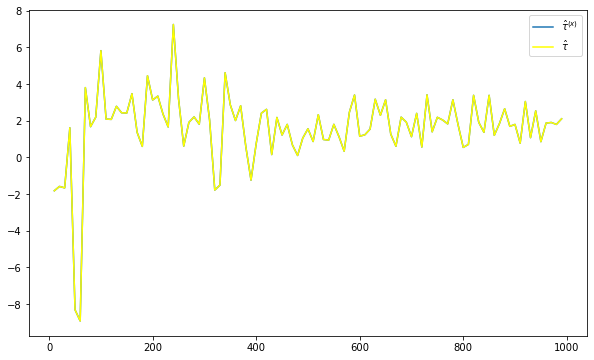

In [86]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}$',color = 'yellow')
plt.legend()

In [79]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,3,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 216.57it/s]


In [80]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.07149157535742068, RMSE=3.0427570470520573, size=0.054
N=1000: bias=-0.0077731221216347955, RMSE=0.9825564340579407, size=0.055


Real life example: For example, in the research experiment I mentioned in part 1 A, the differnece is when we want to study the effect of school on student achievement, we need to consider covariates, we study the effect of explanatory variables and covariates on student achievement. Our explanatory variables include education and class and covariates include number of year, background and communication skill. 

In [15]:
g=gr.Digraph()
g.edge("class(C)","Achievement(Y)")
g.edge("education(E)","Achievement(Y)")
g.edge("number of year(X1)","Achievement(Y))
g.edge("background(X2)","Achievement(Y))
g.edge("communication skill(X3)","Achievement(Y))
g

#class influence student achievement
#eduaction influce student achievement 
#number of year as a covariate influce student achievement 
#background as a covariate influce student achievement 
#communication skill as a covariate influce student achievement 

SyntaxError: EOL while scanning string literal (3079601963.py, line 4)

# PART 2 

In part 2, I chose to use the research of Ole Raaschou-Nielsen, Zorana Jovanovic Andersen, Steen Solvang Jensen, Matthias Ketzel, Mette Sorensen, Johnni Hansen, Steffen Loft, Anne Tjonneland and Kim Overvad for the analysis. The authors express in the article that traffic air pollution is associated with cardiovascular mortality, possibly due to co-exposure to road traffic noise. Additionally, personal and lifestyle characteristics may alter any associations. The authors estimated the mortality ratio (MRR) by using a Cox regression model and conducted further analysis and research by potential confounders. In the study, the authors show that traffic air pollution is associated with cardiovascular disease and all-cause mortality. This association was even stronger for those with low fruit and vegetable intake.

reference：Raaschou-Nielsen, O., Andersen, Z.J., Jensen, S.S. et al. Traffic air pollution and mortality from cardiovascular disease and all causes: a Danish cohort study. Environ Health 11, 60 (2012). https://doi.org/10.1186/1476-069X-11-60

# 2. A FAIL TO CONTROL FOR CONFOUNDER

In [32]:
data_source = "https://raw.githubusercontent.com/datadesk/homeless-sleeping-restrictions/master/output/joined-buffers-homeless-stats.csv"
data = pd.read_csv(data_source)#where the homeless live, which can reflect their way of life
data

,name,unsheltered,unshelteredoutside,hood_area,buffer_area,pct_of_hood_in_buffer
0,Downtown,2477.656050,2298.862691,5.435817,1.603251,0.294942
1,Skid Row,1560.699515,1511.234336,0.399047,0.185527,0.464925
2,Westlake,1239.655588,921.219987,2.717338,1.692640,0.622904
3,Historic South-Central,944.710611,673.731808,2.555178,1.343640,0.525850
4,Hollywood,1191.539096,634.890246,3.502332,1.749808,0.499612
...,...,...,...,...,...,...
110,Larchmont,3.229615,3.129461,0.483013,0.210864,0.436560
111,Chatsworth Reservoir,0.756257,0.176586,1.802363,0.214292,0.118895
112,Porter Ranch,142.443669,0.125707,5.585676,1.619233,0.289890
113,Beverly Crest,0.082356,0.066498,8.236458,2.322563,0.281986


In [33]:
tau = 2
corr = .5
conf=False # I failed to control for confonder
p = 15
p0 = 0 
Nrange = range(10,1000,10) 
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 430.58it/s]


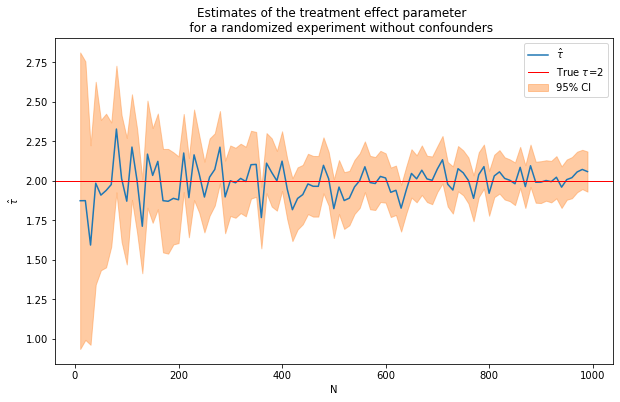

In [34]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [35]:
N = 100
Yexp,T = fn_generate_data(tau,N,15,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [36]:
tauhat,se_tauhat

(1.644047376022416, 0.18168441465024032)

In [37]:
const = np.ones([N,1])

In [38]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(1.6440473760224157, 0.1816844146502403)

In [39]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,15,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 190.64it/s]


In [40]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0010229025465232997, RMSE=0.20363656435472613, size=0.053
N=1000: bias=0.00019972112647580965, RMSE=0.06327964006136107, size=0.053


Real life example: For example, in the research experiment I mentioned in part 2， When we looked at the linear relationship between traffic air pollution and cardiovascular mortality of homeless (I chose to study homeless in this relationship because they are more representative of the problem.), we only had explanatory variable （traffic air pollution） and dependent variable （cardiovascular mortality） in this section since we did not control for the confounders

In [17]:
g=gr.Digraph()
g.edge("traffic air pollution（T)","cardiovascular mortality(Y)")
g

# I just know traffic air pollution influence cardiovascular mortality becasue I failed to control for confounder

NameError: name 'gr' is not defined

# 2.B CONTROL FOR THE CONFOUNDER

In [41]:
data_source = "https://raw.githubusercontent.com/datadesk/homeless-sleeping-restrictions/master/output/joined-buffers-homeless-stats.csv"
data = pd.read_csv(data_source)#where the homeless live, which can reflect their way of life
data

,name,unsheltered,unshelteredoutside,hood_area,buffer_area,pct_of_hood_in_buffer
0,Downtown,2477.656050,2298.862691,5.435817,1.603251,0.294942
1,Skid Row,1560.699515,1511.234336,0.399047,0.185527,0.464925
2,Westlake,1239.655588,921.219987,2.717338,1.692640,0.622904
3,Historic South-Central,944.710611,673.731808,2.555178,1.343640,0.525850
4,Hollywood,1191.539096,634.890246,3.502332,1.749808,0.499612
...,...,...,...,...,...,...
110,Larchmont,3.229615,3.129461,0.483013,0.210864,0.436560
111,Chatsworth Reservoir,0.756257,0.176586,1.802363,0.214292,0.118895
112,Porter Ranch,142.443669,0.125707,5.585676,1.619233,0.289890
113,Beverly Crest,0.082356,0.066498,8.236458,2.322563,0.281986


In [42]:
tau = 2
corr = .5
conf= True # I control for the confounder
p = 15
p0 = 0 
Nrange = range(10,1000,10) 
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 426.81it/s]


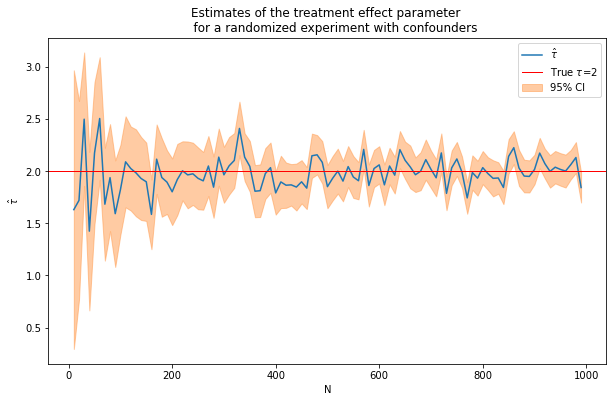

In [43]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [44]:
N = 100
Yexp,T = fn_generate_data(tau,N,15,0,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [45]:
tauhat,se_tauhat

(2.298247667325647, 0.21600837146845991)

In [46]:
const = np.ones([N,1])

In [47]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(2.298247667325647, 0.21600837146845991)

In [48]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,15,0,corr,conf= True)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 184.61it/s]


In [49]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.021244257406197082, RMSE=0.23386568357807005, size=0.0515
N=1000: bias=0.003627883211367178, RMSE=0.07161187893612253, size=0.0435


Real life example: For example, in the research experiment I mentioned in part 2 A， the difference is When we looked at the linear relationship between traffic air pollution and cardiovascular mortality, we need to consider the confounders. Therefore,  we had explanatory variable （traffic air pollution）,confounde(personal eating habits） and dependent variable （cardiovascular mortality） in this section。In addition, confounder affect  explanatory variable and dependent variable directly.

In [19]:
g=gr.Digraph()
g.edge("traffic air pollution（T)","cardiovascular mortality(Y)")
g.edge("personal eating habits（H)","cardiovascular mortality(Y)")
g.edge("personal eating habits（H)","traffic air pollution（T)")
g

#traffic air pollution as explanation variable influence cardiovascular mortality directly 
#personal eating habits as a confounder influence cardiovascular mortality directly 
##personal eating habits as a confounder influence traffic air pollution directly and influence cardiovascular mortality indirectly 


NameError: name 'gr' is not defined

# PART 3

In part 3, I chose to use the study of Dominique and Pri-fen as the analysis factor for part 3. The authors analyzed how site selection effects affect the safety and efficacy of treatment by quantifying selection bias in treatment safety and efficacy according to different entry criteria and factors associated with crash data. The authors differentiated the treatment group from the control group by quantifying selection bias in the safety and efficacy of the treatment, analyzed and studied. The authors stated that the significant effects of selection bias were felt across all methods evaluated. In addition, the authors state their findings that higher entry criteria, larger safety-effectiveness values, and smaller values for the dispersion parameter lead to greater selection bias.

reference: Lord, D., &amp; Kuo, P.-F. (2012, February 3). Examining the effects of site selection criteria for evaluating the effectiveness of traffic safety countermeasures. Accident Analysis &amp; Prevention. Retrieved April 12, 2022, from https://www.sciencedirect.com/science/article/pii/S0001457511003368?casa_token=Cl-xGF0d8a8AAAAA%3AB889bmXCQOc3PIy6vRki6Rh3qv47qw9DR3WENDKNjh75bzBvY8BcexaSacF6udza6AM_nduT 

# 3 A control for the variable in between the path from cause to effect

In [82]:
data_source = "https://raw.githubusercontent.com/datadesk/ripa-analysis/master/data/LAPD_online_data_since_July_2018.csv"
data = pd.read_csv(data_source)#the data of LAPD Involvement in Traffic Accidents
data.head(30)# this data is very large, therefore I just select first 30 rows

/Users/yuhengdu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Stop Number,FRN,Sex Code,Descent Code,Descent Description,Stop Date,Stop Time,Officer 1 Serial Number,Officer 1 Division Number,Division Description 1,Officer 2 Serial Number,Officer 2 Division Number,Division Description 2,Reporting District,Stop Type,Post Stop Activity Indicator
0,14960244,31299287,M,H,HISPANIC,4/26/2019,10:35,20543.0,80,**UNUSED PIU CODE**,16725.0,80,**UNUSED PIU CODE**,111,PED,Y
1,14496306,30897159,M,A,ASIAN,8/9/2018,6:25,26222.0,46,**UNUSED PIU CODE**,11856.0,46,**UNUSED PIU CODE**,119,PED,Y
2,14615250,30999328,F,W,WHITE,10/4/2018,22:42,21978.0,66,**UNUSED PIU CODE**,60319.0,66,**UNUSED PIU CODE**,119,PED,N
3,14942792,31284744,F,W,WHITE,4/18/2019,14:40,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,119,PED,Y
4,14942795,31284740,F,B,BLACK,4/18/2019,14:28,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,119,PED,Y
5,14826931,31183858,M,H,HISPANIC,2/13/2019,17:30,22252.0,80,**UNUSED PIU CODE**,16060.0,80,**UNUSED PIU CODE**,127,PED,N
6,14942794,31284752,M,B,BLACK,4/18/2019,15:00,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,132,PED,Y
7,14965929,31304677,M,B,BLACK,4/29/2019,14:25,22619.0,46,**UNUSED PIU CODE**,NaN,46,**UNUSED PIU CODE**,132,PED,N
8,14606315,30991618,M,W,WHITE,9/29/2018,17:17,26386.0,46,**UNUSED PIU CODE**,11634.0,46,**UNUSED PIU CODE**,153,PED,Y
9,14943353,31285240,M,B,BLACK,4/18/2019,21:10,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,153,PED,Y


In [83]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 20
Nrange = range(100,1000,10) 
flagX = 1 # I control for the variable in between the path from cause to effect, therefore, I need need to start with more observations than p
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████████████████████████████████████| 90/90 [00:00<00:00, 126.85it/s]


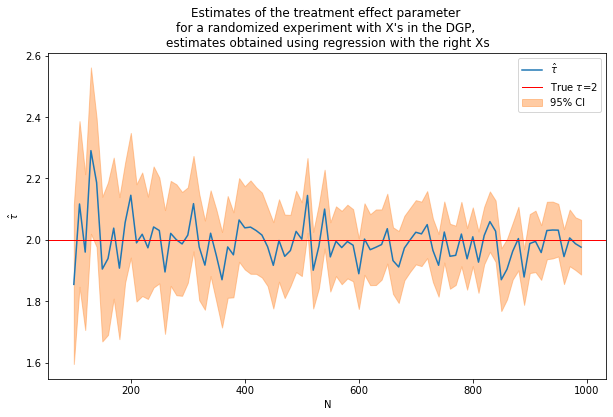

In [84]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [85]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,20,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [86]:
tauhat,se_tauhat

(1.9195053012943637, 10.087158666170486)

In [87]:
const = np.ones([N,1])

In [88]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(1.9195053012943633, 10.087158666170486)

In [89]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,20,corr,conf= False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 99.25it/s]


In [90]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.19052086225303816, RMSE=14.63783420919088, size=0.047
N=1000: bias=0.048001281936792234, RMSE=4.9550147820046, size=0.0545


Real life example: For example, in the research experiment I mentioned in part 3, When I want to analyzed how site selection effects affect the safety and efficacy of treatment by treatment group and control group, and quantifying selection bias. I need to control explanation variable and selection bias. THerefore, I need to consider how explanation variable (location) and selection bias (traffic) influcence dependent variable (safety and efficacy of treatment).

In [37]:
g=gr.Digraph()
g.edge("Location（X)","safety and efficacy of treatment(Y)")
g.edge("Traffic（T)","safety and efficacy of treatment(Y)")
g
#Location as explanation variable influence safety and efficacy of treatment
#Traffic as a selecting bias influence safety and efficacy of treatment

NameError: name 'gr' is not defined

# 3. B do not control for the variable in between the path from cause to effect

In [92]:
data_source = "https://raw.githubusercontent.com/datadesk/ripa-analysis/master/data/LAPD_online_data_since_July_2018.csv"
data = pd.read_csv(data_source)#the data of LAPD Involvement in Traffic Accidents
data.head(30)# this data is very large, therefore I just select first 30 rows

/Users/yuhengdu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Stop Number,FRN,Sex Code,Descent Code,Descent Description,Stop Date,Stop Time,Officer 1 Serial Number,Officer 1 Division Number,Division Description 1,Officer 2 Serial Number,Officer 2 Division Number,Division Description 2,Reporting District,Stop Type,Post Stop Activity Indicator
0,14960244,31299287,M,H,HISPANIC,4/26/2019,10:35,20543.0,80,**UNUSED PIU CODE**,16725.0,80,**UNUSED PIU CODE**,111,PED,Y
1,14496306,30897159,M,A,ASIAN,8/9/2018,6:25,26222.0,46,**UNUSED PIU CODE**,11856.0,46,**UNUSED PIU CODE**,119,PED,Y
2,14615250,30999328,F,W,WHITE,10/4/2018,22:42,21978.0,66,**UNUSED PIU CODE**,60319.0,66,**UNUSED PIU CODE**,119,PED,N
3,14942792,31284744,F,W,WHITE,4/18/2019,14:40,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,119,PED,Y
4,14942795,31284740,F,B,BLACK,4/18/2019,14:28,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,119,PED,Y
5,14826931,31183858,M,H,HISPANIC,2/13/2019,17:30,22252.0,80,**UNUSED PIU CODE**,16060.0,80,**UNUSED PIU CODE**,127,PED,N
6,14942794,31284752,M,B,BLACK,4/18/2019,15:00,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,132,PED,Y
7,14965929,31304677,M,B,BLACK,4/29/2019,14:25,22619.0,46,**UNUSED PIU CODE**,NaN,46,**UNUSED PIU CODE**,132,PED,N
8,14606315,30991618,M,W,WHITE,9/29/2018,17:17,26386.0,46,**UNUSED PIU CODE**,11634.0,46,**UNUSED PIU CODE**,153,PED,Y
9,14943353,31285240,M,B,BLACK,4/18/2019,21:10,21978.0,66,**UNUSED PIU CODE**,13145.0,66,**UNUSED PIU CODE**,153,PED,Y


In [93]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 20
Nrange = range(100,1000,10) 
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████████████████████████████████████| 90/90 [00:00<00:00, 128.43it/s]


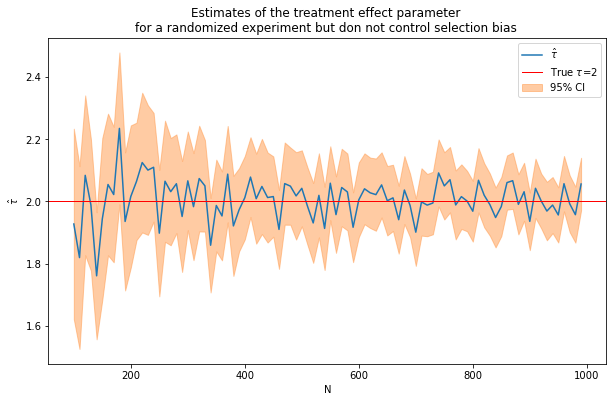

In [94]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment but don not control selection bias """
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [95]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,20,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [96]:
tauhat,se_tauhat

(-23.830874438752854, 17.47900502274164)

In [97]:
const = np.ones([N,1])

In [98]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(-23.83087443875285, 17.47900502274164)

In [99]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,20,corr,conf= False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 102.24it/s]


In [100]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.07080605444518748, RMSE=15.50063990568, size=0.0565
N=1000: bias=0.05616296054842951, RMSE=4.799291542810524, size=0.049


Real life example: For example, in the research experiment I mentioned in part 3, When I want to analyzed how site selection effects affect the safety and efficacy of treatment by treatment group and control group and I don't control the seletion bias, we just control the explanation variable that is the location. Therefore, I just consider how explanation variable (location) influcence dependent variable (safety and efficacy of treatment).

In [36]:
g=gr.Digraph()
g.edge("Location（X)","safety and efficacy of treatment(Y)")
g
#Location as explanation variable influence safety and efficacy of treatment

NameError: name 'gr' is not defined